In [4]:
!pip install pyspark
!pip install findspark

In [5]:
import findspark
findspark.init()
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Combine CASTNET Files")
         .config("spark.ui.port", "4050")
         .getOrCreate())

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [6]:
import os
import shutil
import sys
import time
import numpy as np
import pandas as pd
from google.colab import drive

drive_root = "/content/drive"
drive.mount(drive_root)

file_directory = os.path.join(drive_root, "My Drive", "AML Group 24")
os.listdir(file_directory)

FILE_OUTPUT = "output"
if not os.path.exists(FILE_OUTPUT):
    os.makedirs(FILE_OUTPUT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
met_gas_loc = os.path.join(file_directory, "met_gas_site.snappy.parquet")
result = pd.read_parquet(met_gas_loc)
display(result)

,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_F,TEMPERATURE_DELTA,TEMPERATURE_DELTA_F,RELATIVE_HUMIDITY,RELATIVE_HUMIDITY_F,SOLAR_RADIATION,SOLAR_RADIATION_F,...,NOY,NOYDIF,NOY_MINUS,SO2_GA,TNX,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN
0,BEL116,2013-01-01 22:00:00,3.8590,None,0.0440,None,67.7900,None,0.4750,None,...,None,None,None,0.9990,None,39.028177,-76.817127,47.00000,Range,Flat
1,BEL116,2013-01-02 03:00:00,1.5730,None,0.0570,None,63.0100,None,0.4710,None,...,None,None,None,2.3820,None,39.028177,-76.817127,47.00000,Range,Flat
2,BEL116,2013-01-02 07:00:00,-0.3470,None,0.1750,None,64.3200,None,9.4500,None,...,None,None,None,2.9260,None,39.028177,-76.817127,47.00000,Range,Flat
3,BEL116,2013-01-02 08:00:00,-0.4400,None,0.0530,None,64.2200,None,106.4000,None,...,None,None,None,2.8350,None,39.028177,-76.817127,47.00000,Range,Flat
4,BEL116,2013-01-02 15:00:00,1.4860,None,-0.1930,None,44.6300,S,182.8000,None,...,None,None,None,1.3170,None,39.028177,-76.817127,47.00000,Range,Flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574846,ROM206,2022-12-21 05:00:00,-4.1350,None,None,M,None,M,None,M,...,0.1260,0.0940,None,None,None,40.278129,-105.545635,2742.00000,Forest,Complex
574847,ROM206,2022-12-23 10:00:00,-0.6020,None,None,M,None,M,None,M,...,0.2490,0.1020,None,None,None,40.278129,-105.545635,2742.00000,Forest,Complex
574848,ROM206,2022-12-29 04:00:00,-8.8900,None,None,M,None,M,None,M,...,0.6840,0.6620,None,None,None,40.278129,-105.545635,2742.00000,Forest,Complex
574849,ROM206,2022-12-30 21:00:00,-2.6780,None,None,M,None,M,None,M,...,0.1110,0.0800,None,None,None,40.278129,-105.545635,2742.00000,Forest,Complex


In [8]:
result.columns

Index(['SITE_ID', 'DATE_TIME', 'TEMPERATURE', 'TEMPERATURE_F',
       'TEMPERATURE_DELTA', 'TEMPERATURE_DELTA_F', 'RELATIVE_HUMIDITY',
       'RELATIVE_HUMIDITY_F', 'SOLAR_RADIATION', 'SOLAR_RADIATION_F', 'OZONE',
       'OZONE_F', 'PRECIPITATION', 'PRECIPITATION_F', 'WINDSPEED',
       'WINDSPEED_F', 'WIND_DIRECTION', 'WIND_DIRECTION_F', 'SIGMA_THETA',
       'SIGMA_THETA_F', 'FLOW_RATE', 'FLOW_RATE_F', 'WINDSPEED_SCALAR',
       'WINDSPEED_SCALAR_F', 'WETNESS', 'WETNESS_F', 'SHELTER_TEMPERATURE',
       'SHELTER_TEMPERATURE_F', 'QA_CODE', 'UPDATE_DATE', 'Filename', 'CO',
       'FLOW_23M', 'FLOW_2M', 'HNO3', 'NH3', 'NO', 'NO2_TRUE', 'NOX', 'NOXDIF',
       'NOX_TRUE', 'NOY', 'NOYDIF', 'NOY_MINUS', 'SO2_GA', 'TNX', 'LATITUDE',
       'LONGITUDE', 'ELEVATION', 'LAND_USE', 'TERRAIN'],
      dtype='object')

In [139]:
result[['DATE_TIME','OZONE']]

,DATE_TIME,OZONE
0,2013-01-01 22:00:00,23.3200
1,2013-01-02 03:00:00,30.5300
2,2013-01-02 07:00:00,28.3700
3,2013-01-02 08:00:00,26.0000
4,2013-01-02 15:00:00,33.6900
...,...,...
574846,2022-12-21 05:00:00,47.0300
574847,2022-12-23 10:00:00,45.1300
574848,2022-12-29 04:00:00,40.6300
574849,2022-12-30 21:00:00,46.4600


In [19]:
# Define the upper limits and categories
upper_limits = [54, 70, 85, 105, 200]
categories = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy']

# Function to map ozone concentration to categories
def map_ozone_to_category(concentration):
    for limit, category in zip(upper_limits, categories):
        if concentration <= limit:
            return category
    return categories[-1]  # Default to the last category for values above the highest limit

result['Ozone Category'] = result['OZONE'].apply(map_ozone_to_category)
#result = result.drop(columns=['FLOW_23M','FLOW_2M'])

In [10]:
result[['OZONE', 'Ozone Category']]
result['Ozone Category'].unique()

array(['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy',
       'Very Unhealthy'], dtype=object)

In [20]:
diff_cats = result['Ozone Category'].unique()
for i in diff_cats:
  ct = len(result[result['Ozone Category'] == i])
  print(f"{i}: {ct}")

Good: 533647
Moderate: 39777
Unhealthy for Sensitive Groups: 1370
Unhealthy: 56
Very Unhealthy: 1


In [21]:
#define features and target dataframes
result['Ozone Category'] = result['Ozone Category'].astype('category').cat.codes
result['Ozone Category'] = result['Ozone Category'] + 1
#df_Y = result['Ozone Category']

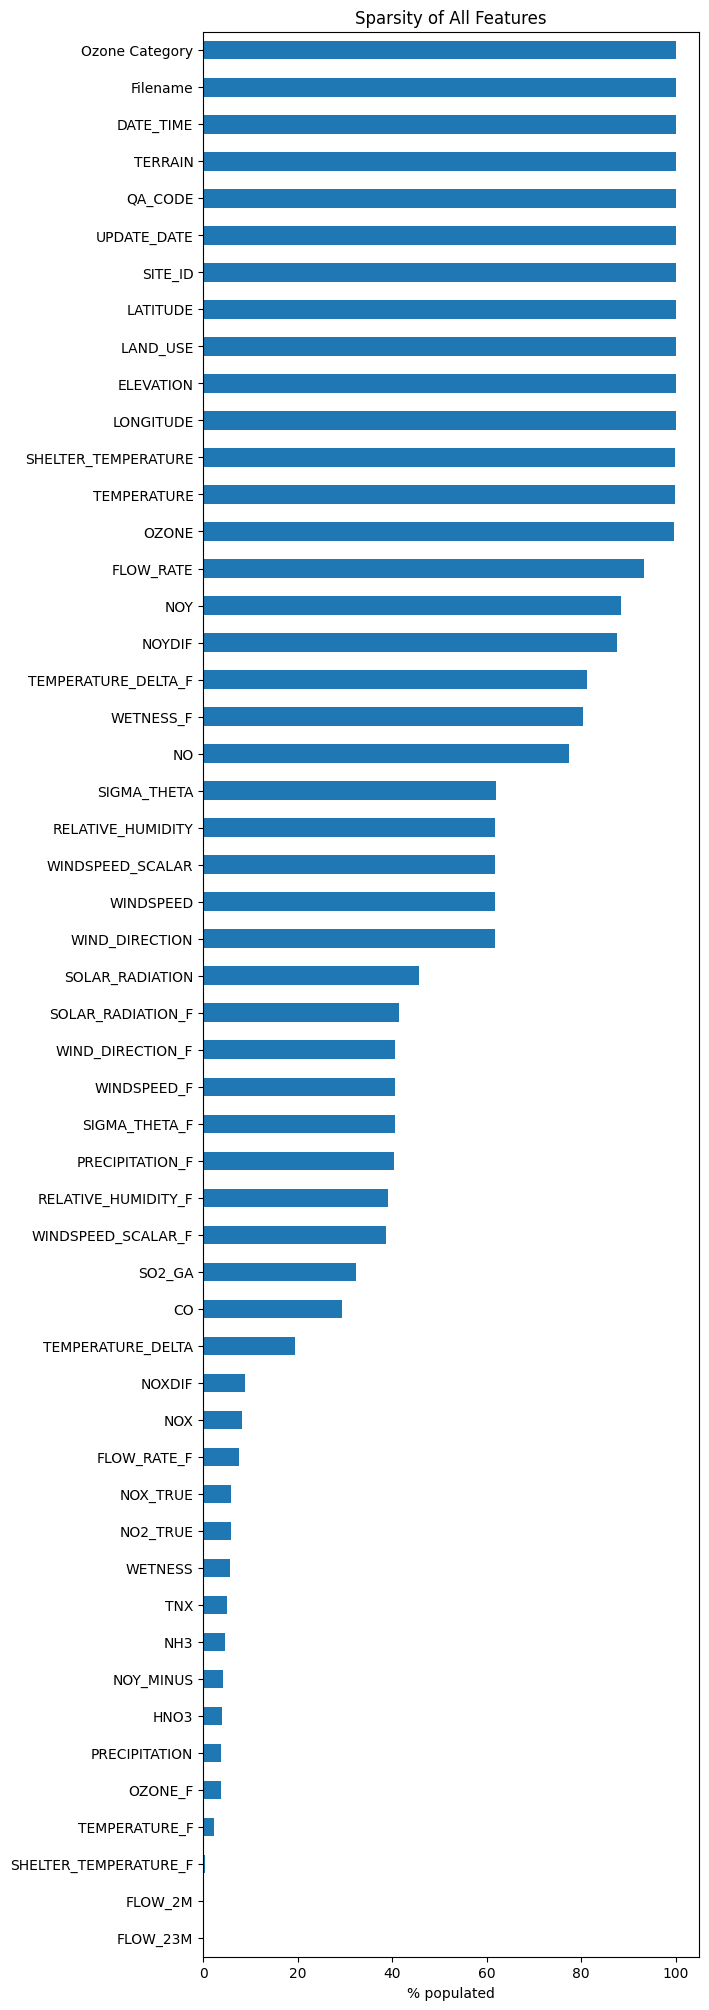

In [22]:
#print out top dense features
sparsity = pd.Series(np.count_nonzero(result, axis=0)*100 / result.shape[0], index = result.columns)
sparse_filtered = sparsity.sort_values(ascending=True)
ax = sparse_filtered.plot.barh(title = "Sparsity of All Features")
ax.set_xlabel("% populated")
ax.figure.set_figheight(25)

In [211]:
sparse_filtered['Filename']

100.0

In [212]:
sparse_filtered.keys()

Index(['FLOW_2M', 'FLOW_23M', 'SHELTER_TEMPERATURE_F', 'TEMPERATURE_F',
       'OZONE_F', 'PRECIPITATION', 'HNO3', 'NOY_MINUS', 'NH3', 'TNX',
       'WETNESS', 'NO2_TRUE', 'NOX_TRUE', 'FLOW_RATE_F', 'NOX', 'NOXDIF',
       'TEMPERATURE_DELTA', 'CO', 'SO2_GA', 'WINDSPEED_SCALAR_F',
       'RELATIVE_HUMIDITY_F', 'PRECIPITATION_F', 'SIGMA_THETA_F',
       'WINDSPEED_F', 'WIND_DIRECTION_F', 'SOLAR_RADIATION_F',
       'SOLAR_RADIATION', 'WIND_DIRECTION', 'WINDSPEED', 'WINDSPEED_SCALAR',
       'RELATIVE_HUMIDITY', 'SIGMA_THETA', 'NO', 'WETNESS_F',
       'TEMPERATURE_DELTA_F', 'NOYDIF', 'NOY', 'FLOW_RATE', 'OZONE',
       'TEMPERATURE', 'SHELTER_TEMPERATURE', 'LONGITUDE', 'ELEVATION',
       'LATITUDE', 'SITE_ID', 'UPDATE_DATE', 'QA_CODE', 'LAND_USE',
       'DATE_TIME', 'Filename', 'TERRAIN'],
      dtype='object')

In [23]:
#given that the data is hourly or taken at 8-10 hour intervals, we can do imputing by forward interpolation
#since in most of the cases, data is available at close time intervals

for feat in sparse_filtered.keys():
  if(sparse_filtered[feat] != 100.0):
    if(sparse_filtered[feat] <= 5.0):
      result.drop(feat, axis=1, inplace=True)
    else:
      result[feat] = result[feat].fillna(method='ffill')
'''
result['TEMPERATURE'] = result['TEMPERATURE'].interpolate(method='linear', limit_direction='forward', axis=0)
result['WINDSPEED'] = result['WINDSPEED'].interpolate(method='linear', limit_direction='forward', axis=0)
result['PRECIPITATION'] = result['PRECIPITATION'].interpolate(method='linear', limit_direction='forward', axis=0)
result[''] = result['TEMPERATURE'].interpolate(method='linear', limit_direction='forward', axis=0)
result['WINDSPEED'] = result['WINDSPEED'].interpolate(method='linear', limit_direction='forward', axis=0)
result['PRECIPITATION'] = result['PRECIPITATION'].interpolate(method='linear', limit_direction='forward', axis=0)
'''
result

,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_DELTA,TEMPERATURE_DELTA_F,RELATIVE_HUMIDITY,RELATIVE_HUMIDITY_F,SOLAR_RADIATION,SOLAR_RADIATION_F,OZONE,...,NOY,NOYDIF,SO2_GA,TNX,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN,Ozone Category
0,BEL116,2013-01-01 22:00:00,3.8590,0.0440,None,67.7900,None,0.4750,None,23.3200,...,None,None,0.9990,None,39.028177,-76.817127,47.00000,Range,Flat,1
1,BEL116,2013-01-02 03:00:00,1.5730,0.0570,None,63.0100,None,0.4710,None,30.5300,...,None,None,2.3820,None,39.028177,-76.817127,47.00000,Range,Flat,1
2,BEL116,2013-01-02 07:00:00,-0.3470,0.1750,None,64.3200,None,9.4500,None,28.3700,...,None,None,2.9260,None,39.028177,-76.817127,47.00000,Range,Flat,1
3,BEL116,2013-01-02 08:00:00,-0.4400,0.0530,None,64.2200,None,106.4000,None,26.0000,...,None,None,2.8350,None,39.028177,-76.817127,47.00000,Range,Flat,1
4,BEL116,2013-01-02 15:00:00,1.4860,-0.1930,None,44.6300,S,182.8000,None,33.6900,...,None,None,1.3170,None,39.028177,-76.817127,47.00000,Range,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574846,ROM206,2022-12-21 05:00:00,-4.1350,1.2700,M,98.0000,M,47.0000,M,47.0300,...,0.1260,0.0940,0.0000,3.3620,40.278129,-105.545635,2742.00000,Forest,Complex,1
574847,ROM206,2022-12-23 10:00:00,-0.6020,1.2700,M,98.0000,M,47.0000,M,45.1300,...,0.2490,0.1020,0.0000,3.3620,40.278129,-105.545635,2742.00000,Forest,Complex,1
574848,ROM206,2022-12-29 04:00:00,-8.8900,1.2700,M,98.0000,M,47.0000,M,40.6300,...,0.6840,0.6620,0.0000,3.3620,40.278129,-105.545635,2742.00000,Forest,Complex,1
574849,ROM206,2022-12-30 21:00:00,-2.6780,1.2700,M,98.0000,M,47.0000,M,46.4600,...,0.1110,0.0800,0.0000,3.3620,40.278129,-105.545635,2742.00000,Forest,Complex,1


In [24]:
result['SITE_ID'] = result['SITE_ID'].astype('category').cat.codes
result['LAND_USE'] = result['LAND_USE'].astype('category').cat.codes
result['TERRAIN'] = result['TERRAIN'].astype('category').cat.codes
result['SITE_ID'] = result['SITE_ID'] + 1
result['LAND_USE'] = result['LAND_USE'] + 1
result['TERRAIN'] = result['TERRAIN'] + 1
#result_X_test = result_X.drop(columns = ['SITE_ID','LAND_USE','TERRAIN'])
#result_X = result.drop(columns=['Ozone Category'])
result.dropna(inplace=True)
df_X = result.drop(columns=['TEMPERATURE_DELTA_F','RELATIVE_HUMIDITY_F', 'SOLAR_RADIATION_F',
                            'PRECIPITATION_F','SIGMA_THETA_F', 'WINDSPEED_F', 'WIND_DIRECTION_F',
                            'FLOW_RATE_F', 'WINDSPEED_SCALAR_F','WETNESS_F', 'OZONE', 'Filename', 'DATE_TIME', 'UPDATE_DATE','QA_CODE','Ozone Category'])
df_Y = result['Ozone Category']

In [188]:
#df_X = df_X.drop(columns = ['SITE_ID','LAND_USE','TERRAIN'])

In [25]:
#split into test and dev sets

from sklearn.model_selection import train_test_split
dev_X, test_X, dev_y, test_y = train_test_split(df_X,df_Y, test_size=0.2, random_state=42)

In [223]:
dev_X

,SITE_ID,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,WINDSPEED_SCALAR,...,NOX_TRUE,NOY,NOYDIF,SO2_GA,TNX,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN
140961,9,1.8140,-0.1770,57.0000,1.0000,1.0000,80.0000,55.0000,3.0010,1.2000,...,1.9520,0.2560,0.2480,0.0000,3.5920,42.929031,-109.787796,2386.00000,3,4
2961,1,3.6320,1.9140,79.3200,0.5780,0.4790,259.1000,17.3600,1.5010,0.5110,...,6.1070,7.3770,2.9440,0.5310,3.5630,39.028177,-76.817127,47.00000,4,2
504773,4,4.0000,1.5470,60.0000,792.0000,2.5000,301.0000,28.0000,1.4970,2.7000,...,1.2040,8.4000,8.1500,-0.3790,4.0370,36.035000,-107.904200,1965.00000,2,1
426758,5,32.0400,-0.2530,89.0000,0.0000,5.2000,233.0000,7.0000,1.4970,5.3000,...,0.5300,0.9690,0.8970,-0.2550,5.9040,35.974500,-79.099000,164.00000,3,4
7125,3,-0.6390,1.1520,79.9900,0.4080,3.9180,226.6000,5.8490,1.5175,3.9930,...,1.0450,5.4000,5.3120,0.3920,2.6500,40.051981,-88.372495,213.00000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,6,0.3000,-0.1770,57.0000,0.0000,3.9000,23.0000,14.0000,3.0000,4.0000,...,1.9520,1.3000,1.5000,0.1000,3.5920,35.633482,-83.941606,793.00000,3,1
259178,3,0.4120,0.5980,67.6500,0.4220,5.0050,157.2000,5.6960,1.5120,5.0330,...,1.6800,8.9900,8.8900,1.7840,6.7180,40.051981,-88.372495,213.00000,1,2
365838,7,19.0700,1.5600,94.0000,0.0000,1.3000,253.0000,35.0000,1.5060,1.5000,...,1.0520,1.6900,1.8250,0.0000,2.8250,43.973044,-74.223317,497.00000,3,1
131932,8,15.4000,-0.1770,73.0000,0.0000,0.6000,131.0000,20.0000,1.5300,0.7000,...,1.9520,2.7000,2.8000,0.0000,3.5920,37.131794,-86.142953,243.00000,1,4


In [27]:
n_features = list(range(1,30))


In [29]:
#scale dev_X values to be all positive
def rescale(data, new_min=0, new_max=1):
    """Rescale the data to be within the range [new_min, new_max]"""
    return (data - data.min()) / (data.max() - data.min()) * (new_max - new_min) + new_min

dev_X = rescale(dev_X)

In [30]:
#try out variance-based filtering to remove unnecessary features
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
dev_scores = []
test_scores = []

for features in n_features:
  pipe = make_pipeline(SelectKBest(chi2, k=features), RandomForestClassifier())
  pipe.fit(dev_X,dev_y)
  dev_scores.append(pipe.score(dev_X,dev_y))
  test_scores.append(pipe.score(test_X,test_y))


ValueError: ignored

In [31]:
dev_scores

[0.9281572263868724,
 0.9281572263868724,
 0.9281616127942731,
 0.9281616127942731,
 0.9281616127942731,
 0.9285278778122354,
 0.9359189742824934,
 0.9391627225553455,
 0.961110111984981,
 0.9611254644108835,
 0.9611298508182843,
 0.9684069006961229,
 0.9688499278435982,
 0.9688565074546994,
 0.9899375814226874,
 0.9999539427222922,
 0.9999736815555955,
 0.999975874759296,
 0.9999692951481948,
 0.9999627155370937,
 0.999964908740794,
 0.9999780679629963,
 0.9999736815555955,
 0.9999780679629963,
 0.999982454370397,
 0.9999780679629963,
 0.9999868407777978]

In [32]:
test_scores


[0.9289756029090527,
 0.9289756029090527,
 0.9289756029090527,
 0.9289756029090527,
 0.9289756029090527,
 0.9288527840405654,
 0.9287036468431165,
 0.9289756029090527,
 0.9288264657116038,
 0.9288352384879243,
 0.9289756029090527,
 0.9289756029090527,
 0.9288352384879243,
 0.9289756029090527,
 0.928914193474809,
 0.46261481371009483,
 0.3307073489547237,
 0.9187728640482854,
 0.7652141873338656,
 0.6811183535253401,
 0.6082165823018011,
 0.7215783979155883,
 0.6050583828264131,
 0.6415619050961058,
 0.6025318232461027,
 0.8636798287554063,
 0.6162612181877198]